In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Load the MNIST dataset, False makes it return the data as a NumPy array
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Flatten the images
X = mnist.data
y = mnist.target
#print(X.shape) #(70000, 784)

# Split the data
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

In [29]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

def filterr(X,y):
    # Keep only the data for digits/classes 3 and 4
    X_filtered = X[(y == 3) | (y == 4)]
    y_filtered = y[(y == 3) | (y == 4)]
    return X_filtered, y_filtered

X_train, y_train = filterr(X_train, y_train)
X_test, y_test = filterr(X_test, y_test)
# Convert labels to integers
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11973, 784)
(11973,)
(1992, 784)
(1992,)


In [30]:
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train)
def convert_34(y_list):
    return np.array([1 if i == 3 else 0 for i in y_list])

def convert_to_34(y_list):
    return np.array([3 if i == 1 else 4 for i in y_list])

y_train = convert_34(y_train)
y_test = convert_34(y_test)

[[-547.48030741 -437.0355941 ]
 [ 552.34261784  751.79342706]
 [-860.21115602  446.88552389]
 ...
 [1012.51158727  468.04068361]
 [ 602.67422673  634.42084587]
 [ 746.38165254  849.62923433]]


# 1.Implement logistic regression

Epoch 10, Loss: 1.110284
Converged at epoch 17, cur loss is: 1.020939


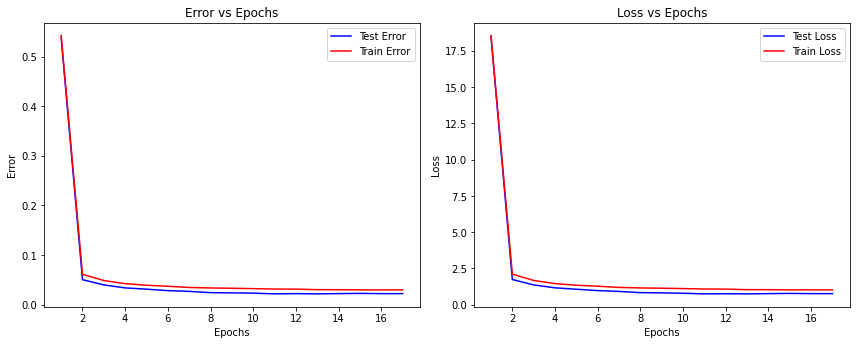

Test Accuracy: 0.9784137


<Figure size 432x288 with 0 Axes>

In [58]:
np.random.seed(99)

def sigmoid(z):
    z = np.clip(z, -500, 500)  # 对输入 z 进行截断，避免溢出
    return 1 / (1 + np.exp(-z))



def compute_loss(y_true, y_pred):
    epsilon = 1e-15  # 用于避免log(0)的情况
    #y_true = convert_34(y_true)
    loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return loss

def get_acc(w, X_test=X_test, y_test=y_test):
    y_pred_test = sigmoid(np.dot(X_test, w))
    y_pred_binary = (y_pred_test >= 0.5).astype(int)
    accuracy = np.mean(y_pred_binary == y_test)
    #print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

def draw(epochs, test_errors, train_errors, test_losses, train_losses, fname='plots.png'):
    plt.figure(figsize=(12, 9))

    # 绘制测试误差和训练误差的图表
    plt.subplot(2, 2, 1)
    plt.plot(epochs, test_errors, label='Test Error', color='blue')  # 设置测试误差的线条颜色为蓝色
    plt.plot(epochs, train_errors, label='Train Error', color='red')  # 设置训练误差的线条颜色为红色
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Error vs Epochs')
    plt.legend(loc='upper right')  # 设置图例位置为右上角

    # 绘制测试损失和训练损失的图表
    plt.subplot(2, 2, 2)
    plt.plot(epochs, test_losses, label='Test Loss', color='blue')  # 设置测试损失的线条颜色为蓝色
    plt.plot(epochs, train_losses, label='Train Loss', color='red')  # 设置训练损失的线条颜色为红色
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend(loc='upper right')  # 设置图例位置为右上角

    plt.tight_layout()
    plt.show()

    plt.savefig(fname) 

def logistic(max_epochs = 100, learning_rate = 0.1, tolerance = 1e-4):
    # Initialize parameters
    w = np.random.randn(X_train.shape[1])

    # Gradient Descent
    prev_loss = float('inf')
    tr_er, tr_lo, ts_er, ts_lo = [], [], [], []
    # train
    for epoch in range(max_epochs):
        y_pred = sigmoid(np.dot(X_train, w))
        loss = compute_loss(y_true=y_train, y_pred=y_pred)
        gradient = np.dot(X_train.T, (y_pred - y_train)) / len(y_train)
        # four things to keep track of 
        # A.train
        tr_lo.append(loss) # 1.train loss
        tr_acc = get_acc(w=w, X_test=X_train, y_test=y_train)
        tr_er.append(1-tr_acc) # 2.train err
        # B.test
        y_pred_test = sigmoid(np.dot(X_test, w))
        loss_test = compute_loss(y_true=y_test, y_pred=y_pred_test)
        ts_lo.append(loss_test) # 3. test loss
        ts_acc = get_acc(w=w, X_test=X_test, y_test=y_test)
        ts_er.append(1-ts_acc) # 4. test err
        
        # Update parameters
        w -= learning_rate * gradient
        #print(f"epoch {epoch+1}, cur loss is: {loss}")
        # Check for convergence
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged at epoch {epoch+1}, cur loss is: {loss:.6f}")
            #draw(list(range(1, epoch+2)), ts_er, tr_er, ts_lo, tr_lo)
            break
        
        prev_loss = loss

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.6f}")

    
    draw(list(range(1, epoch+2)), ts_er, tr_er, ts_lo, tr_lo)
    # Predict on the test set
    y_pred_test = sigmoid(np.dot(X_test, w))

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_test >= 0.5).astype(int)
    #y_pred_binary = convert_to_34(y_pred_binary)

    # Calculate accuracy
    accuracy = np.mean(y_pred_binary == y_test)
    print(f"Test Accuracy: {accuracy:.7f}")
logistic()

6131

# 3. Logistic w/o sigmoid

<ipython-input-58-1e60198cb22a>:12: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))


Converged at epoch 9, cur loss is: 1.021192
Test Accuracy: 0.9779116


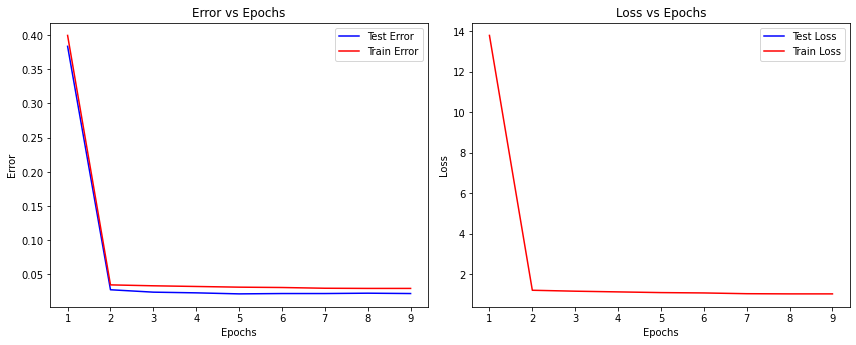

<Figure size 432x288 with 0 Axes>

In [59]:
def get_acc_wos(w, X_test=X_test, y_test=y_test):
    y_pred_test = np.dot(X_test, w)
    y_pred_binary = (y_pred_test >= 0).astype(int)
    accuracy = np.mean(y_pred_binary == y_test)
    #print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

def log_wo_sgm(max_epochs = 100, learning_rate = 0.01, tolerance = 1e-4):
    # Initialize parameters
    w = np.random.randn(X_train.shape[1])

    # Gradient Descent
    prev_loss = float('inf')
    tr_er, tr_lo, ts_er, ts_lo = [], [], [], []
    # train
    for epoch in range(max_epochs):
        y_pred = np.dot(X_train, w)
        y_pred = (y_pred >= 0).astype(int)
        loss = compute_loss(y_true=y_train, y_pred=y_pred)
        gradient = np.dot(X_train.T, (y_pred - y_train)) / len(y_train)
        # four things to keep track of 
        # A.train
        tr_lo.append(loss) # 1.train loss
        tr_acc = get_acc_wos(w=w, X_test=X_train, y_test=y_train)
        tr_er.append(1-tr_acc) # 2.train err
        # B.test
        y_pred_test = np.dot(X_test, w)
        loss_test = compute_loss(y_true=y_test, y_pred=y_pred_test)
        ts_lo.append(loss_test) # 3. test loss
        ts_acc = get_acc_wos(w=w, X_test=X_test, y_test=y_test)
        ts_er.append(1-ts_acc) # 4. test err
        
        # Update parameters
        w -= learning_rate * gradient
        #print(f"epoch {epoch+1}, cur loss is: {loss}")
        # Check for convergence
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged at epoch {epoch+1}, cur loss is: {loss:.6f}")
            #draw(list(range(1, epoch+2)), ts_er, tr_er, ts_lo, tr_lo)
            #print(ts_acc)
            print(f"Test Accuracy: {ts_acc:.7f}")
            break
        
        prev_loss = loss

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.6f}")

    
    draw(list(range(1, epoch+2)), ts_er, tr_er, ts_lo, tr_lo)
    
log_wo_sgm()

# 4. Non-zero bias

Epoch 10, Loss: 1.087540
Epoch 20, Loss: 0.994933
Epoch 30, Loss: 0.986551
Converged at epoch 31, cur loss is: 0.986554


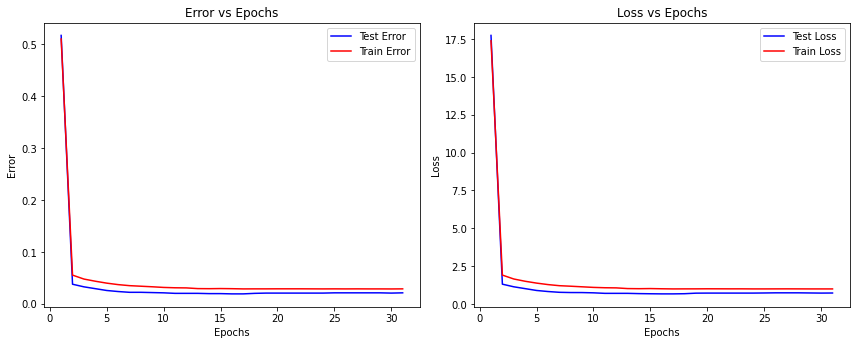

Test Accuracy: 0.97892


<Figure size 432x288 with 0 Axes>

In [57]:
def log_w_bias(max_epochs = 100, learning_rate = 0.1, tolerance = 1e-4):
    # Initialize parameters
    w = np.random.randn(X_train.shape[1])

    # Gradient Descent
    prev_loss = float('inf')
    tr_er, tr_lo, ts_er, ts_lo = [], [], [], []
    # train
    for epoch in range(max_epochs):
        y_pred = sigmoid(np.dot(X_train, w)+1)
        loss = compute_loss(y_true=y_train, y_pred=y_pred)
        gradient = np.dot(X_train.T, (y_pred - y_train)) / len(y_train)
        # four things to keep track of 
        # A.train
        tr_lo.append(loss) # 1.train loss
        tr_acc = get_acc(w=w, X_test=X_train, y_test=y_train)
        tr_er.append(1-tr_acc) # 2.train err
        # B.test
        y_pred_test = sigmoid(np.dot(X_test, w)+1)
        loss_test = compute_loss(y_true=y_test, y_pred=y_pred_test)
        ts_lo.append(loss_test) # 3. test loss
        ts_acc = get_acc(w=w, X_test=X_test, y_test=y_test)
        ts_er.append(1-ts_acc) # 4. test err
        
        # Update parameters
        w -= learning_rate * gradient
        #print(f"epoch {epoch+1}, cur loss is: {loss}")
        # Check for convergence
        if abs(prev_loss - loss) < tolerance:
            print(f"Converged at epoch {epoch+1}, cur loss is: {loss:.6f}")
            #draw(list(range(1, epoch+2)), ts_er, tr_er, ts_lo, tr_lo)
            break
        
        prev_loss = loss

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss:.6f}")

    
    draw(list(range(1, epoch+2)), ts_er, tr_er, ts_lo, tr_lo)
    # Predict on the test set
    y_pred_test = sigmoid(np.dot(X_test, w)+1)

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_test >= 0.5).astype(int)
    #y_pred_binary = convert_to_34(y_pred_binary)

    # Calculate accuracy
    accuracy = np.mean(y_pred_binary == y_test)
    print(f"Test Accuracy: {accuracy:.5f}")
log_w_bias()

In [60]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')